In [3]:
import pandas as pd
import json
from datetime import datetime
import plotly.express as px
from pathlib import Path
from matplotlib.pyplot import ScalarFormatter
from harbor.analysis.cross_docking import DockingDataModel
import seaborn as sns
from matplotlib import pyplot as plt

In [4]:
data = DockingDataModel.deserialize("/Users/alexpayne/Scientific_Projects/mers-drug-discovery/sars2-retrospective-analysis/full_cross_dock_v2_combined_results/ALL_1_poses.parquet")

In [27]:
ref_df = data.dataframe.groupby("Reference_Ligand").head(1)
query_df = data.dataframe.groupby("Query_Ligand").head(1)

# INCREMENT SCAFFOLD ID BY 1

In [28]:
ref_df['RefData_Scaffold_ID'] = ref_df['RefData_Scaffold_ID'].apply(lambda x: x + 1)

/var/folders/cf/d42qwdmd5_g5s63r3g_vgx2c0000gn/T/ipykernel_49163/3021020067.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['RefData_Scaffold_ID'] = ref_df['RefData_Scaffold_ID'].apply(lambda x: x + 1)


## count number of structures per cluster

In [29]:
cluster_counts = ref_df.groupby('RefData_Scaffold_ID').count().reset_index()[['RefData_Scaffold_ID', 'Reference_Ligand']]
cluster_counts.columns = ['RefData_Scaffold_ID', 'count']

## get earliest date for each cluster

In [30]:
date_df = ref_df.sort_values('RefData_Date').groupby("RefData_Scaffold_ID").first().reset_index()[['RefData_Scaffold_ID', 'RefData_Date', "RefData_Scaffold_Smarts"]].sort_values('RefData_Date')

### combine data

In [31]:
df = cluster_counts.merge(date_df, on='RefData_Scaffold_ID')

In [32]:
df.columns = ['scaffold_orig_id', 'scaffold_count', 'scaffold_first_date', 'scaffold_smarts']

### I only have smiles for the queries

In [37]:
ligand_df = ref_df[["Reference_Ligand", "RefData_Scaffold_ID", "RefData_Date", "RefData_Scaffold_Smarts"]]

In [38]:
query_smiles = query_df[["Query_Ligand", "PoseData_SMILES"]]

In [41]:
ligand_df = ligand_df.merge(query_smiles, left_on='Reference_Ligand', right_on='Query_Ligand').drop(columns=['Query_Ligand'])

In [42]:
ligand_df.columns = ['compound_name', 'scaffold_orig_id', 'compound_date', 'scaffold_smarts', 'smiles']

## add scaffold data to ligand_df

In [43]:
ligand_df = ligand_df.merge(df, on='scaffold_orig_id', how='left', suffixes=['', '_from_scaff_data']).reset_index()

### make sure scaffold smarts is the same

In [44]:
ligand_df[ligand_df['scaffold_smarts'] != ligand_df['scaffold_smarts_from_scaff_data']]

,index,compound_name,scaffold_orig_id,compound_date,scaffold_smarts,smiles,scaffold_count,scaffold_first_date,scaffold_smarts_from_scaff_data
89,89,AAR-POS-d2a4d1df-17,105,2020-03-06 07:11:07,None,CCC(=[NH2+])N,1,2020-03-06 07:11:07,None


"AAR-POS-d2a4d1df-17" doesn't have a scaffold smarts?

### make sure compound_date is always after or equal to scaffold_date

In [45]:
all(ligand_df['compound_date'] >= ligand_df['scaffold_first_date'])

True

yay!

# Plotting variables

In [46]:
# Global configuration
fig_path = Path("./20250703_scaffolds_over_time")
fig_path.mkdir(parents=True, exist_ok=True)

FIGNUM_GLOBAL = 0

# def save_fig(fig, filename, dpi=200, suffix=".pdf"):
#     """Save the figure with a global figure number."""
#     global FIGNUM_GLOBAL
#     FIGNUM_GLOBAL += 1
#     figpath = Path(fig_path / f"{filename}_{FIGNUM_GLOBAL:02d}")
#     fig.savefig(figpath.with_suffix(suffix), 
#                 bbox_inches="tight", 
#                 dpi=dpi)

def save_fig(fig, filename, dpi=200, suffix=".pdf"):
    figpath = Path(fig_path / f"{filename}")
    fig.savefig(figpath.with_suffix(suffix), 
                bbox_inches="tight", 
                dpi=dpi)
    

sns.set_style("white")
label_map = {
    "Reference_Split": "Dataset Split Type",
    "Score": "Scoring Method",
    "RandomSplit": "Randomly Ordered",
    "DateSplit": "Ordered by Date",
    "RMSD": "RMSD (Positive Control)",
    "POSIT_Probability": "POSIT Probability",
    # "PairwiseSplit": "Similarity Metric",
    "Similarity_Threshold": "Similarity Threshold",
    "ECFP4_2048": "ECFP4 2048",
    "MCS": "MCS",
    "TanimotoCombo_True": "Tanimoto Combo (Aligned)",
    # "N_Reference_Structures": "Number of Randomly Chosen Reference Structures",
    "N_Reference_Structures": "Number of Reference Structures Available to Use \n(Log Scale)",
    "Fraction": "Fraction of Ligands Posed \n<2Å from Reference",
    "CI_Lower": "Confidence Interval Lower Bound",
    "CI_Upper": "Confidence Interval Upper Bound",
    
}
        
X_VAR = label_map["N_Reference_Structures"]
Y_VAR = label_map["Fraction"]
X_LABEL = label_map["N_Reference_Structures"]
Y_LABEL = label_map["Fraction"]
# QUERY_SCAFFOLD_ID = label_map["Query_Scaffold_ID_Subset_1"]
# REF_SCAFFOLD_ID = label_map["Reference_Scaffold_ID_Subset_1"]
COLOR_VAR = label_map["Reference_Split"]
STYLE_VAR = label_map["Score"]
CI_LOWER = label_map["CI_Lower"]
CI_UPPER = label_map["CI_Upper"]
LARGE_FIG_SIZE = (12, 8)
SMALL_FIG_SIZE = (8, 6)
FONT_SIZES = {
    "xlabel": 24,
    "ylabel": 24,
    "ticks": 18,
    "legend_title": 24,
    "legend_text": 18,
}
ALPHA = 0.1

# Plot Scaffolds Over Time

In [47]:
def make_image(df,x_col = "Date", color="cluster_id"):
    import plotly.express as px

    large_font = 24
    small_font = 18

    fig = px.ecdf(
        df,
        x=x_col,
        color=color,
        ecdfnorm=None,
        template="simple_white",
        height=600,
        width=800,
    )
    # update legend title
    fig.update_layout(legend_title_text="<b> Scaffold </b>")
    fig.update_xaxes(title_text="<b> Date of Crystal Structure Collection </b>")
    fig.update_yaxes(title_text="<b> Cumulative Number of Structures </b>")

    update_layout_dict = dict(
        xaxis=dict(
            title_font=dict(size=large_font),
            color="black",
        ),
        yaxis=dict(
            # range=(0,1),
            title_font=dict(size=large_font),
            color="black",
        ),
    )

    # move legend to inside the plot
    fig.update_layout(
        legend=dict(yanchor="bottom", y=0.25, xanchor="right", x=1.1),
        **update_layout_dict,
    )

    return fig

In [48]:
pdf = ligand_df.sort_values("scaffold_count", ascending=False)

In [49]:
min_counts = 8
labels = []
for row in pdf.itertuples():
    if row.scaffold_count > min_counts:
        labels.append(f'Scaffold {row.scaffold_orig_id} - {row.scaffold_count} Molecules')
    else:
        labels.append(f'Misc Scaffolds - {sum(pdf.scaffold_count <= min_counts)} Molecules')

In [50]:
pdf["simplified_scaffold_ids"] = labels

In [51]:
fig = make_image(pdf, x_col="compound_date", color="simplified_scaffold_ids")
fig.write_image(fig_path / "scaffs_over_time_grouped.svg")

In [52]:
fig = make_image(pdf, x_col="compound_date", color="scaffold_orig_id")
fig.write_image(fig_path / "scaffs_over_time.svg")

# save svg of all scaffolds

In [53]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor

In [54]:
# get tuple of scaffold_id and rdkit mol
scaffold_mols = df.copy()
scaffold_mols['scaffold_mol'] = scaffold_mols.scaffold_smarts.apply(lambda x: Chem.MolFromSmiles(x) if x is not None else None)

In [55]:
def draw_single_mol(mol, fn, size=(400, 400)):
    mol = Chem.RemoveHs(mol)
    rdDepictor.Compute2DCoords(mol)
    rdDepictor.StraightenDepiction(mol)
    
    # Create the drawing object
    drawer = Draw.rdMolDraw2D.MolDraw2DSVG(*size)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    with open(fn, "w") as f:
        f.write(svg)
    
    img = Draw.MolsToImage([mol], subImgSize=size, legends=[f"Scaffold {row.scaffold_orig_id}"])
    img.save(fn.with_suffix(".png"))

In [56]:
scaff_dir = fig_path / "scaffolds"
scaff_dir.mkdir(exist_ok=True)
for i, row in scaffold_mols.iterrows():
    if row.scaffold_mol is not None:
        row.scaffold_mol.SetProp("_Name", f"Scaffold {row.scaffold_orig_id}")
        draw_single_mol(row.scaffold_mol, scaff_dir / f"generic_scaffold_{row.scaffold_orig_id}.svg")

# Plot histogram of mols per scaffold

In [57]:
pdf

,index,compound_name,scaffold_orig_id,compound_date,scaffold_smarts,smiles,scaffold_count,scaffold_first_date,scaffold_smarts_from_scaff_data,simplified_scaffold_ids
245,245,ALP-UNI-3735e77e-2,1,2021-02-12 13:17:37,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,c1ccc2c(c1)cncc2NC(=O)[C@@H]3CCOc4c3cc(cc4Cl)Cl,62,2020-09-15 19:26:20,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,Scaffold 1 - 62 Molecules
323,323,MAT-POS-96f51285-5,1,2021-04-15 12:54:00,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,c1cc2cncc(c2cc1F)NC(=O)[C@@H]3CCOc4c3cc(c(c4)F)Cl,62,2020-09-15 19:26:20,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,Scaffold 1 - 62 Molecules
279,279,EDG-MED-70ae9412-2,1,2021-02-12 14:44:58,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,C[NH+](C)CC(=O)NC[C@]1(CCOc2c1cc(cc2)Cl)C(=O)N...,62,2020-09-15 19:26:20,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,Scaffold 1 - 62 Molecules
246,246,EDG-MED-971238d3-1,1,2021-02-12 13:48:37,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,c1ccc2c(c1)cncc2NC(=O)[C@@]3(CCOc4c3cc(cc4)Cl)O,62,2020-09-15 19:26:20,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,Scaffold 1 - 62 Molecules
290,290,MAT-POS-fb82b63d-3,1,2021-04-15 18:16:54,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,C[N@@H+]1CCc2ccc(cc2[C@@H]1C(=O)Nc3cncc4c3cccc...,62,2020-09-15 19:26:20,CC(CC1CCCC2CCCCC21)C1CCCC2CCCCC21,Scaffold 1 - 62 Molecules
...,...,...,...,...,...,...,...,...,...,...
276,276,RAL-THA-8416115c-5,48,2021-02-12 13:39:34,CC(CC1CCCC2CCCCC21)C1CCC(CC2CCCC2)C2CCCCC12,c1ccc2c(c1)cncc2NC(=O)[C@@H]3CCN(c4c3cc(cc4)Cl...,1,2021-02-12 13:39:34,CC(CC1CCCC2CCCCC21)C1CCC(CC2CCCC2)C2CCCCC12,Misc Scaffolds - 218 Molecules
113,113,JAN-GHE-83b26c96-21,90,2020-06-30 21:11:36,CC(C)(CC1CCCCC1)C1CCCCC1,Cc1ccncc1NS(=O)(=O)c2cccc(c2)Cl,1,2020-06-30 21:11:36,CC(C)(CC1CCCCC1)C1CCCCC1,Misc Scaffolds - 218 Molecules
182,182,MAR-UCB-f313ec4d-2,94,2020-10-09 00:26:20,CC(CCCCC1CCCCC1)C1CCCC2CCCCC21,COc1ccccc1OCCNC(=O)c2cncc3c2cccc3,1,2020-10-09 00:26:20,CC(CCCCC1CCCCC1)C1CCCC2CCCCC21,Misc Scaffolds - 218 Molecules
181,181,ALP-POS-0c2c77e1-1,87,2020-09-16 13:37:49,CC(CC1CCCCC1)CC1CCCCC1C1CCCCC1,c1ccc(cc1)c2ccncc2NC(=O)Cc3cccc(c3)Cl,1,2020-09-16 13:37:49,CC(CC1CCCCC1)CC1CCCCC1C1CCCCC1,Misc Scaffolds - 218 Molecules


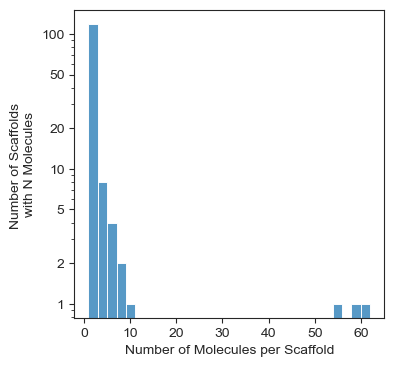

In [58]:
sns.set_style("ticks")
plt.figure(figsize=(4,4))
ax = sns.histplot(df, x="scaffold_count", binwidth=2)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
from itertools import product
custom_ticks = list([a*b for a,b in product([1,2,5], [1,10,100]) if a*b <= 100])
ax.set_yticks(custom_ticks)
ax.set_ylabel("Number of Scaffolds \nwith N Molecules")
ax.set_xlabel("Number of Molecules per Scaffold")
save_fig(plt.gcf(), "scaffold_histogram")

# write out scaffold df

In [59]:
ligand_df.to_csv("ligand_scaffold_data.csv", index=False)